In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import cv2
import os
import glob
import re
import os

def triangulate(w,h,markers):
    vertices=[[-0.1*w,-0.1*h,-0.1*w,-0.1*h],
             [ 1.1*w,-0.1*h, 1.1*w,-0.1*h],
             [-0.1*w, 1.1*h,-0.1*w, 1.1*h],
             [ 1.1*w, 1.1*h, 1.1*w, 1.1*h]]
    edges=[0]*((len(markers)+4)*(len(markers)+4-1)//2)
    triangles=[Triangle(0,1,2,vertices,edges),Triangle(1,2,3,vertices,edges)]
    edges[0]=edges[1]=edges[4]=edges[5]=2
    for marker in markers:
        x,y=marker[2:4]
        found=False
        keep=[]
        remove=[]
        for triangle in triangles:
            if not found and triangle.intriangle(x,y):
                found=True
            if triangle.incircle(x,y):
                remove.append(triangle)
            else:
                keep.append(triangle)
        if found:
            for triangle in remove:
                triangle.removeedges()
        else:
            keep.extend(remove)
        triangles=keep
        vcount=len(vertices)
        vertices.append(marker)
        for i in range(vcount-1):
            for j in range(i+1,vcount):
                if edges[edgeindex(i,j)]==1:
                    triangles.append(Triangle(i,j,vcount,vertices,edges))
    return triangles

def transform(triangulation,x,y):
    for triangle in triangulation:
        uv1=triangle.intriangle(x,y)
        if uv1:
            return (triangle.A[0]
               +(triangle.B[0]-triangle.A[0])*uv1[0]
               +(triangle.C[0]-triangle.A[0])*uv1[1],
               triangle.A[1]
               +(triangle.B[1]-triangle.A[1])*uv1[0]
               +(triangle.C[1]-triangle.A[1])*uv1[1])

def forwardtransform(triangulation,x,y):
    for triangle in triangulation:
        uv1=triangle.inforward(x,y)
        if uv1:
            return(triangle.A[2]
             +(triangle.B[2]-triangle.A[2])*uv1[0]
             +(triangle.C[2]-triangle.A[2])*uv1[1],
               triangle.A[3]
             +(triangle.B[3]-triangle.A[3])*uv1[0]
             +(triangle.C[3]-triangle.A[3])*uv1[1])
def inv3x3(m):
    det = m[0][0] * (m[1][1] * m[2][2] - m[2][1] * m[1][2])\
       - m[0][1] * (m[1][0] * m[2][2] - m[1][2] * m[2][0])\
       + m[0][2] * (m[1][0] * m[2][1] - m[1][1] * m[2][0])
    if det == 0:
        return None
    return [[(m[1][1] * m[2][2] - m[2][1] * m[1][2]) / det,
            (m[0][2] * m[2][1] - m[0][1] * m[2][2]) / det,
            (m[0][1] * m[1][2] - m[0][2] * m[1][1]) / det],
           [(m[1][2] * m[2][0] - m[1][0] * m[2][2]) / det,
            (m[0][0] * m[2][2] - m[0][2] * m[2][0]) / det,
            (m[1][0] * m[0][2] - m[0][0] * m[1][2]) / det],
           [(m[1][0] * m[2][1] - m[2][0] * m[1][1]) / det,
            (m[2][0] * m[0][1] - m[0][0] * m[2][1]) / det,
            (m[0][0] * m[1][1] - m[1][0] * m[0][1]) / det]]

def rowmul3(v,m):return [sum(v[j]*m[j][i] for j in range(3)) for i in range(3)]
def distsquare(ax,ay,bx,by):return (ax-bx)*(ax-bx)+(ay-by)*(ay-by)
def edgeindex(a,b):i=min(a,b);j=max(a,b);return j*(j-1)//2+i
   
class Triangle:
    def __init__(self,a,b,c,vlist,elist):
        self.A=vlist[a]
        self.B=vlist[b]
        self.C=vlist[c]
        self.elist=elist
        self.edges=[edgeindex(a,b),
                   edgeindex(a,c),
                   edgeindex(b,c)]
        for edge in self.edges:
            elist[edge]+=1
        ax,ay=self.A[0:2]
        bx,by=self.B[0:2]
        cx,cy=self.C[0:2]
        self.forwarddecomp=inv3x3([[bx-ax,by-ay,0],
                                  [cx-ax,cy-ay,0],
                                  [ax,ay,1]])
        ax,ay=self.A[2:4]
        bx,by=self.B[2:4]
        cx,cy=self.C[2:4]
        self.decomp=inv3x3([[bx-ax,by-ay,0],
                           [cx-ax,cy-ay,0],
                           [ax,ay,1]])
        a2=distsquare(bx,by,cx,cy)
        b2=distsquare(ax,ay,cx,cy)
        c2=distsquare(ax,ay,bx,by)
        fa=a2*(b2+c2-a2)
        fb=b2*(c2+a2-b2)
        fc=c2*(a2+b2-c2)
        self.den=fa+fb+fc
        self.Mdenx=fa*ax+fb*bx+fc*cx
        self.Mdeny=fa*ay+fb*by+fc*cy
        self.r2den=distsquare(ax*self.den,ay*self.den,self.Mdenx,self.Mdeny)

    def removeedges(self):
        for edge in self.edges:
            self.elist[edge]-=1
        del self.edges
        del self.elist

    def incircle(self,x,y):
        return distsquare(x*self.den,y*self.den,self.Mdenx,self.Mdeny)<self.r2den

    def intriangle(self,x,y):
        uv1=rowmul3([x,y,1],self.decomp)
        if 0<=uv1[0]<=1 and 0<=uv1[1]<=1 and uv1[0]+uv1[1]<=1:
            return uv1

    def inforward(self,x,y):
        uv1=rowmul3([x,y,1],self.forwarddecomp)
        if 0<=uv1[0]<=1 and 0<=uv1[1]<=1 and uv1[0]+uv1[1]<=1:
            return uv1

def get_adjusted_points(df):
    
    slice_num = df['slice'].iloc[0]
    jpg_file=name_df[name_df['slicenum']==slice_num]['json_name'].values[0]
    s = details.get(jpg_file)
    width = s['width']
    height = s['height']
    triangulation = triangulate(width,height,s["markers"])
    return df.apply(lambda x: pd.Series(transform(triangulation, x['rescale_x'], x['rescale_y'])), axis = 1)


### double check the image name before run
def get_slice_file(slice_num):
    if slice_num<=100:
        name = 'Slice' + str(slice_num).rjust(2, '0') + '.jpg'
    else:
        name='Slice' + str(slice_num)+'.jpg'    
    return name




def get_quicknii_cord(slice_num, df,height,width):
    height = height
    width = width
    image_file = name_df[name_df['slicenum']==slice_num]['json_name'].iloc[0]
    record=anchor[anchor['filename']==image_file].iloc[0]
    matrix_1=np.array([[record['ux'],record['uy'],record['uz']],[record['vx'],record['vy'],record['vz']],[record['ox'],record['oy'],record['oz']]])
    i = df[['adjusted_x']].values/width
    j = df[['adjusted_y']].values/height
    c = np.ones((len(i),1))
    new_cor = np.matmul(np.hstack((i,j,c)), matrix_1)
    df.loc[:, ['x_Quicknii', 'y_Quicknii', 'z_Quicknii']] = new_cor
    return df

def get_vox_cord(df, vox_size=25):
    new_cor = np.hstack((df[['x_Quicknii', 'y_Quicknii', 'z_Quicknii']], np.ones((df.shape[0], 1))))
    matrix_allen=np.array([[0,0,25,0],[-25,0,0,0],[0,-25,0,0],[13175,7975,0,1]])   ##Matrix from their paper
    final_m = np.matmul(new_cor,matrix_allen)/vox_size
    df.loc[:, ['x_CCF', 'y_CCF', 'z_CCF', 'c']] = final_m
    return df

def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

home_path=os.getcwd()
os.chdir('./newsliceimages/small')


scaling_factor=0.2;

image_files=glob.glob('Slice*.jpg')
slicenum=[]
for i in image_files:     
    result=re.search('Slice(.*).jpg', i)
    n=result.group(1)
    slicenum+=[n]
flat_name=[]  
for i in image_files:
    result=re.search('(.*).jpg', i)
    n=result.group(1)+('_nl.flat')
    flat_name+=[n]

slicenum=[int(i) for i in slicenum]


im = cv2.imread(image_files[0])
w=im.shape[1]
h=im.shape[0]

json_name=image_files 
d = {'slicenum': slicenum, 'json_name': json_name,'flat_name':flat_name}
name_df=pd.DataFrame(data=d)

os.chdir('../..')
neurons=pd.read_csv('filt_neurons.csv')
neurons=neurons[neurons['slice'].isin(slicenum)]
Max=neurons['x'].max()
Min=neurons['y'].max()
neurons['rescale_x']=(neurons['x']*scaling_factor)
neurons['rescale_y']=(neurons['y']*scaling_factor)

os.chdir('./newsliceimages/small')
with open("visualign.json") as f:
    vafile=json.load(f)
details={s.get('filename'):s for s in vafile['slices']}

neurons[['adjusted_x', 'adjusted_y']] = neurons.groupby('slice').apply(get_adjusted_points)
neurons_nl=neurons.copy()

## check the adjusted coordinates

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


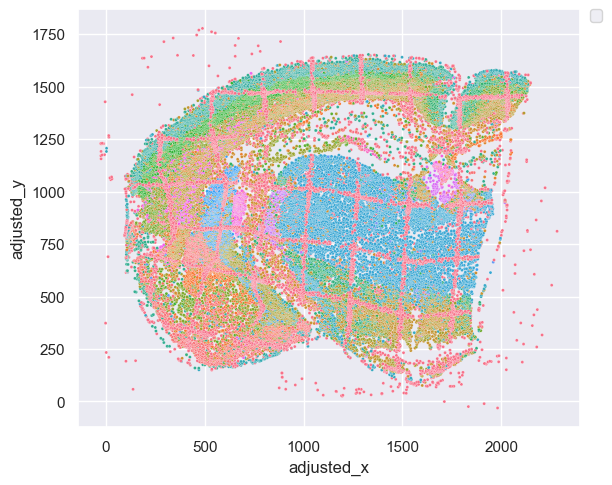

In [19]:
sns.set(rc={'figure.figsize': (Max/2000, Min/2000)})
g = sns.scatterplot(data=neurons_nl[neurons_nl['slice']==17], x='adjusted_x', y='adjusted_y', hue='clustid',
                     legend=False, s=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [21]:
f = open('quicknii.json','r')
data=json.loads(f.read())
def get_record(s):
    return {
        'filename':s.get('filename'),
        'height': s.get('height'),
        'width': s.get('width'), 
        'ox': s.get('anchoring')[0], 
        'oy': s.get('anchoring')[1],
        'oz': s.get('anchoring')[2],
        'ux': s.get('anchoring')[3],
        'uy': s.get('anchoring')[4],
        'uz': s.get('anchoring')[5], 
        'vx': s.get('anchoring')[6], 
        'vy': s.get('anchoring')[7],
        'vz': s.get('anchoring')[8],
    }
anchor=pd.DataFrame.from_records([get_record(s) for s in data['slices']])
f.close()

vox_dfs = []
for slice_num, df in neurons_nl.groupby('slice'):
    quicknii_cord = get_quicknii_cord(slice_num, df,h,w) # Height and Width of image file
    vox_cord = get_vox_cord(quicknii_cord)
    vox_dfs += [vox_cord]
    
vox_df = pd.concat(vox_dfs)
os.chdir('../..')
vox_df.to_csv('registered_filt_neurons.csv',index=False)

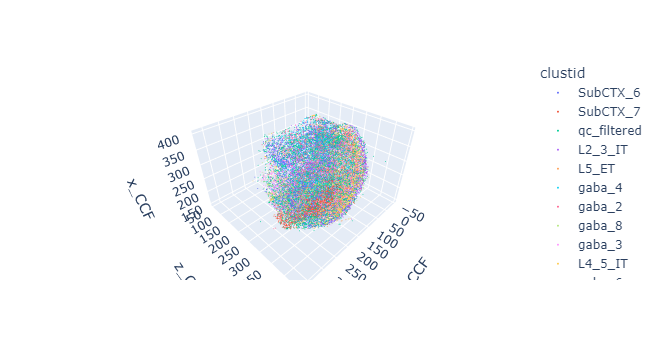

In [22]:
plot_df=vox_df.sample(30000)
fig = px.scatter_3d(plot_df, x='y_CCF', y='z_CCF', z='x_CCF', color='clustid')
#fig.update_traces(marker=dict(size=0.5, color=plot_df['hex_color']),
#                  selector=dict(mode='markers')

fig.update_traces(marker=dict(size=0.5),
                  selector=dict(mode='markers'))

fig.show()